In [1]:
import numpy as np
import tensorflow as tf
from sonnet.python.modules.basic import Linear
from sonnet.python.modules.base import AbstractModule

LEARNING_RATE = 1e-3
_EPSILON = 1e-6 # avoid nan
ENTROPY_BETA = 10
GAMMA = 0.9 # discount factor
VALUE_BETA = 0.5

In [2]:
def swich(tensor):
    return tensor * tf.nn.sigmoid(tensor + _EPSILON)

# shared neural network
def _build_shared_network(inputs):
    # inputs [batch_size, state_size]
    network = Linear(32, 'input_layer')(inputs)
    return swich(network)


class build_policy_network(AbstractModule):
    def __init__(self, name):
        super().__init__(name=name)
        
    def _build(self, inputs, action_size):
        shared_network = _build_shared_network(inputs)
        policy = Linear(32, 'policy_input')(shared_network)
        policy = swich(policy)
        policy = Linear(action_size, 'policy_output')(policy)
        return tf.nn.softmax(policy + _EPSILON) # avoid nan   

    
class build_value_network(AbstractModule):
    def __init__(self, name):
        super().__init__(name=name)
        
    def _build(self, inputs):
        shared_network = _build_shared_network(inputs)
        value = Linear(32, 'value_input')(shared_network)
        value = swich(value)
        value = Linear(1, 'value_output')(value)
        return value
    
    
# build approximate neural network
def _build_approximate_network(inputs, action_size):
    shared_network = _build_shared_network(inputs)
    
    policy = Linear(32, 'policy_input')(shared_network)
    policy = swich(policy)
    policy = Linear(action_size, 'policy_output')(policy)
    policy = tf.nn.softmax(policy + _EPSILON) # avoid nan   
    
    value = Linear(32, 'value_input')(shared_network)
    value = swich(value)
    value = Linear(1, 'value_output')(value)
    return policy, value

class simple_approximate_network(AbstractModule):
    def __init__(self, name):
        super().__init__(name=name)
    
    def _build(self, inputs, action_size):
        return _build_approximate_network(inputs, action_size)
        
# batch gather function from https://github.com/deepmind/dnc/blob/master/util.py
def _batch_gather(values, indices):
    """Returns batched `tf.gather` for every row in the input."""
    with tf.name_scope('batch_gather', values=[values, indices]):
        unpacked = zip(tf.unstack(values), tf.unstack(indices))
        result = [tf.gather(value, index) for value, index in unpacked]
        return tf.stack(result)

In [3]:
# test
tf.reset_default_graph()
state = tf.placeholder(tf.float32, [None, 4], 'inputs')

policy_network = build_policy_network('global_policy')
policy_network(state, 2)


<tf.Tensor 'global_policy/Softmax:0' shape=(?, 2) dtype=float32>

In [4]:
policy_network.get_variables()

(<tf.Variable 'global_policy/linear/w:0' shape=(4, 32) dtype=float32_ref>,
 <tf.Variable 'global_policy/linear/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'global_policy/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'global_policy/linear_1/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'global_policy/linear_2/w:0' shape=(32, 2) dtype=float32_ref>,
 <tf.Variable 'global_policy/linear_2/b:0' shape=(2,) dtype=float32_ref>)

In [5]:
tf.reset_default_graph()
state = tf.placeholder(tf.float32, [None, 4], 'inputs')

value_network = build_value_network('global_value')
value_network(state)

<tf.Tensor 'global_value/linear_2/add:0' shape=(?, 1) dtype=float32>

In [6]:
value_network.get_variables()

(<tf.Variable 'global_value/linear/w:0' shape=(4, 32) dtype=float32_ref>,
 <tf.Variable 'global_value/linear/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'global_value/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'global_value/linear_1/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'global_value/linear_2/w:0' shape=(32, 1) dtype=float32_ref>,
 <tf.Variable 'global_value/linear_2/b:0' shape=(1,) dtype=float32_ref>)

In [7]:
# global network for buffer weights and calculate gardients
class Access(object):
    def __init__(self, state_size, action_size, name='access'):
        #variable_scope for more clear graph, not necessary
        with tf.variable_scope(name):                   
            # placeholder for state and next state or you may like call it observation
            self.inputs = tf.placeholder(tf.float32, [None, state_size], 'inputs')     
            #self.network = simple_approximate_network('global_network')
            #self.policy, self.value = self.network(self.inputs, action_size)
            self.policy_network = build_policy_network('global_policy')
            self.value_network = build_value_network('global_value')
            self.policy = self.policy_network(self.inputs, action_size)
            self.value = self.value_network(self.inputs)
            
        self.optimizer_actor = tf.train.RMSPropOptimizer(LEARNING_RATE, name='optimizer_actor')
        self.optimizer_critic = tf.train.RMSPropOptimizer(LEARNING_RATE, name='optimizer_critic') 
        
    def get_trainable_variables(self):
        return [self.policy_network.get_variables(), self.value_network.get_variables()]

In [8]:
# test
tf.reset_default_graph()
A = Access(4, 2)

In [9]:
A.get_trainable_variables()

[(<tf.Variable 'access/global_policy/linear/w:0' shape=(4, 32) dtype=float32_ref>,
  <tf.Variable 'access/global_policy/linear/b:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'access/global_policy/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
  <tf.Variable 'access/global_policy/linear_1/b:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'access/global_policy/linear_2/w:0' shape=(32, 2) dtype=float32_ref>,
  <tf.Variable 'access/global_policy/linear_2/b:0' shape=(2,) dtype=float32_ref>),
 (<tf.Variable 'access/global_value/linear/w:0' shape=(4, 32) dtype=float32_ref>,
  <tf.Variable 'access/global_value/linear/b:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'access/global_value/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
  <tf.Variable 'access/global_value/linear_1/b:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'access/global_value/linear_2/w:0' shape=(32, 1) dtype=float32_ref>,
  <tf.Variable 'access/global_value/linear_2/b:0' shape=(1,) dtype=float32_ref>)]

In [10]:
# local network for advantage actor-critic which are also know as A2C
class ACNet(object):
    def __init__(self, Access, state_size, action_size, name):
        self.Access = Access
        self.state_size = state_size
        self.action_size = action_size
        # action space, we assume that action space is range(0 to action_size-1)
        self.action_space = np.arange(action_size, dtype=np.int32)
        
        #variable_scope local graph, necessary
        with tf.variable_scope(name):
            # placeholder for state and next state or you may like call it observation
            self.inputs = tf.placeholder(tf.float32, [None, state_size], 'inputs')   
            self.action = tf.placeholder(tf.int32, [None], 'action')
            # n-step reward and discounted n next step value
            self.target = tf.placeholder(tf.float32, [None, 1], 'target')
            
            self.policy_network = build_policy_network('global_policy')
            self.value_network = build_value_network('global_value')
            self.policy = self.policy_network(self.inputs, action_size)
            self.value = self.value_network(self.inputs)
            
            self._build_loss_function()
            self.update_local, self.update_access = self._build_update()         
        
    def _build_loss_function(self):
        self.advantage = self.target - self.value
        # value loss
        self.value_loss = tf.reduce_mean(tf.square(self.advantage))
    
        # policy loss
        # get the stochastic policy action probability
        #policy_action = _batch_gather(self.policy, self.action)
        action_onehot = tf.one_hot(self.action, self.action_size)
        policy_action = tf.reduce_sum(self.policy * action_onehot, axis=1, keep_dims=True)
        log_policy_action = tf.log(policy_action + _EPSILON)
        # no grad pass through advantage in actor network 
        policy_loss = tf.stop_gradient(self.advantage) * tf.expand_dims(log_policy_action, axis=1)
        # entropy loss
        entropy_loss = tf.reduce_mean(self.policy * tf.log(self.policy + _EPSILON), axis=1, keep_dims=True)
        self.policy_loss = tf.reduce_mean(policy_loss + ENTROPY_BETA * entropy_loss)

        # adjust some params
        self.a_policy_loss = tf.reduce_mean(policy_loss)
        self.a_entropy_loss = tf.reduce_mean(ENTROPY_BETA * entropy_loss)
        self.a_value_loss = self.value_loss

    def _build_update(self):
        global_policy_params, global_value_params = self.Access.get_trainable_variables()
        local_policy_params = self.policy_network.get_variables()
        local_value_params = self.value_network.get_variables()
        
        policy_list = []
        for g,l in zip(global_policy_params, local_policy_params):
            policy_list.append(l.assign(g))
            
        value_list = []
        for g,l in zip(global_value_params, local_value_params):
            value_list.append(l.assign(g))        
        
        policy_grad = tf.gradients(self.policy_loss, list(local_policy_params))
        value_grad = tf.gradients(self.value_loss, list(local_value_params))
        
        policy_apply = self.Access.optimizer_actor.apply_gradients(zip(policy_grad, list(global_policy_params)))
        value_apply = self.Access.optimizer_critic.apply_gradients(zip(value_grad, list(global_value_params)))
        return [policy_list, value_list], [policy_apply, value_apply]    
    
    def choose_action(self, SESS, state):  # run by a local
        policy = SESS.run(self.policy, {self.inputs: np.expand_dims(state, axis=0)})
        policy = np.squeeze(policy)
        action = np.random.choice(self.action_space, 1, p=policy)
        return action

In [11]:
tf.reset_default_graph()
A = Access(4, 2)
W1 = ACNet(A, 4, 2, 'W1')

In [12]:
import gym

GAME = 'CartPole-v0'
env = gym.make(GAME)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

MAX_EPISODES = 10000
T_MAX = 10

In [13]:
tf.reset_default_graph()
SESS = tf.Session()
with tf.device("/cpu:0"):
    master = Access(state_size, action_size)
    worker = ACNet(master, state_size, action_size, 'W0')
    SESS.run(tf.global_variables_initializer())
    
    episode_score_list = []
    episode = 0
    while episode < MAX_EPISODES:
        
        t_start = t = 1
        state = env.reset()
        
        buffer_state = []
        buffer_reward = []
        buffer_next_state = []
        episode_score = 0
        
        while True:
            SESS.run(worker.update_local)
            action = worker.choose_action(SESS, state)[0]
            next_state, reward, done, info = env.step(action)
            episode_score += reward
            
            buffer_state.append(state)
            buffer_reward.append(reward)
            buffer_next_state.append(next_state)
            state = next_state

            if t - t_start == T_MAX or done:
                t_start = t
                            
                if done:
                    state_value = 0
                else:
                    state_value = SESS.run(worker.value, {worker.inputs:np.expand_dims(state, axis=0)})[0][0]
                    
                buffer_target = []
                for r in buffer_reward[:-1][::-1]:
                    state_value = r + GAMMA * state_value
                    buffer_target.append(state_value)
                buffer_target.reverse()
                
                feed_dict = {worker.inputs: np.vstack(buffer_state[:-1]), 
                             worker.action: np.squeeze(np.vstack(buffer_reward[:-1]), axis=1), 
                             worker.target: np.expand_dims(np.array(buffer_target), axis=1)}
                SESS.run(worker.update_access, feed_dict)
                
                if done:
                    if episode > 9990:
                        entropy_loss, policy_loss, value_loss = SESS.run(
                            [worker.a_entropy_loss, worker.a_policy_loss, worker.a_value_loss],
                            feed_dict)         
                        print (entropy_loss, policy_loss, value_loss)

                        policy, advantage = SESS.run([worker.policy, worker.advantage], feed_dict)
                        print (policy)
                        print (advantage)
                
                buffer_state = [buffer_state[-1]]
                buffer_reward = [buffer_reward[-1]]
                buffer_next_state = [buffer_next_state[-1]]
                
            t += 1
            if done:
                episode +=1
                episode_score_list.append(episode_score)
                break
            

-3.44622 0.176361 0.231128
[[ 0.49149686  0.5085032 ]
 [ 0.50325364  0.49674636]
 [ 0.48817959  0.51182044]
 [ 0.46823886  0.53176111]
 [ 0.44359338  0.55640662]
 [ 0.41486967  0.58513033]]
[[-0.31211376]
 [-0.9579134 ]
 [-0.5170238 ]
 [-0.19052696]
 [ 0.05043638]
 [ 0.25611442]]
-3.44661 0.403376 0.45878
[[ 0.46955764  0.53044242]
 [ 0.44623551  0.55376446]]
[[-0.81697667]
 [-0.50010991]]
-3.44488 -0.172246 0.379189
[[ 0.48409194  0.51590806]
 [ 0.46674979  0.53325021]
 [ 0.48672178  0.51327825]
 [ 0.46822205  0.53177798]
 [ 0.44653374  0.55346626]
 [ 0.42218962  0.57781035]
 [ 0.44436392  0.55563611]]
[[-0.40218067]
 [ 0.23497343]
 [-0.49358463]
 [ 0.12038279]
 [ 0.62364459]
 [ 1.07420444]
 [ 0.79774392]]
-3.46018 -0.379111 0.609704
[[ 0.50864553  0.49135438]
 [ 0.49535754  0.50464249]
 [ 0.50844342  0.49155653]
 [ 0.49405298  0.50594705]
 [ 0.4754352   0.5245648 ]
 [ 0.49204674  0.50795329]
 [ 0.47160101  0.52839893]
 [ 0.44754523  0.55245477]]
[[-0.18834972]
 [ 0.69402361]
 [-0.327

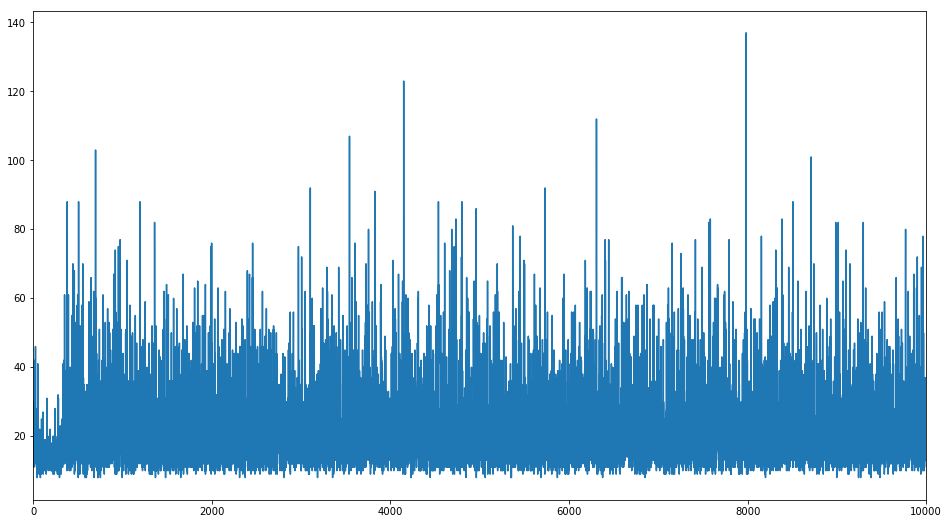

In [14]:
%matplotlib inline
import pandas as pd

pd.Series(episode_score_list).plot(figsize=(16,9))

In [15]:
tf.trainable_variables()

[<tf.Variable 'access/global_policy/linear/w:0' shape=(4, 32) dtype=float32_ref>,
 <tf.Variable 'access/global_policy/linear/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'access/global_policy/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'access/global_policy/linear_1/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'access/global_policy/linear_2/w:0' shape=(32, 2) dtype=float32_ref>,
 <tf.Variable 'access/global_policy/linear_2/b:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear/w:0' shape=(4, 32) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear_1/w:0' shape=(32, 32) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear_1/b:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear_2/w:0' shape=(32, 1) dtype=float32_ref>,
 <tf.Variable 'access/global_value/linear_2/b:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'W0/